In [1]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='f3fbc885-6ed4-465d-84c0-ad2309925735', project_access_token='p-cb1d35677742f5653d2c82bbe6a9daadd9a09944')
pc = project.project_context


# Battle of Neighborhoods 


This section describes in detail the steps performed to analyze data from sources mentioned above.

In [2]:
# Import necessary python packages and define constants for later use.
!conda install -c conda-forge folium=0.5.0 --yes
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import requests
import json
from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim
import seaborn as sns
import folium
import folium.plugins
from folium.plugins import MarkerCluster
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
import os
import math
from os import listdir
from os.path import isfile, join
import matplotlib as mlt
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import locale
locale.setlocale(locale.LC_ALL, '')
print('Libraries imported.')

#define constants
BASE_URL = 'https://api.foursquare.com/v2'
CLIENT_ID = ''
CLIENT_SECRET = ''
V='20180604'
print('Libraries imported/constants defines.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    altair-4.0.0               |             py_0         606 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.1 MB

The following NEW packages will be 

<b>Foursquare</b>¶
I defined a function to search for venues located in Buenos Aires, Ciudad Autonama de Buenos Aires (CABA)
Next, I use Foursquare API to pull the list of top 100 venues within 500 meters radius. In order to acess foursquare data, I signed up for a Foursquare developer account which proides the names, categories, latitude and longitude of the venues. 

##### Venue Data: Buenos Aires' venues data from Foursquare

In [3]:
CLIENT_ID = '4E0ZDFALAXG5UWXDPLSNWHJ2XC5B3YJUQHW50BJGEKG51DKS' #  Foursquare ID
CLIENT_SECRET = '3CJAM1LI0J2Z4NZJ1L0YL3ABW40QIZBYZKUK4UPBXBGPI3B1' #  Foursquare Secret
VERSION = '20180604'
LIMIT = 100
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

CLIENT_ID: 4E0ZDFALAXG5UWXDPLSNWHJ2XC5B3YJUQHW50BJGEKG51DKS
CLIENT_SECRET:3CJAM1LI0J2Z4NZJ1L0YL3ABW40QIZBYZKUK4UPBXBGPI3B1


In [4]:
address = 'Ciudad Autonoma de Buenos Aires, Argentina'
geolocator = Nominatim(user_agent="t_explorer")
location = geolocator.geocode(address)
cabalat = location.latitude
cabalong = location.longitude
print('CABAs geograpical coordinates {}, {}.'.format(cabalat, cabalong))

CABAs geograpical coordinates -34.6075616, -58.437076.


##### Neighborhood Data: Buenos Aires' neighborhoods and borough data from Gobierno Abierto

In [6]:
barriosfilename= "https://raw.githubusercontent.com/karin-datascientist/Coursera_Capstone/master/barrios-comunas-data.csv"
barriosheaders = ['barrios','comuna','crime','income','property_value','barrio_lat','barrio_long','comuna_lat','comuna_long']
barrios = pd.read_csv(barriosfilename, names = barriosheaders)

In [5]:
url = 'https://api.foursquare.com/v2/venues/explore?&client_id=4E0ZDFALAXG5UWXDPLSNWHJ2XC5B3YJUQHW50BJGEKG51DKS&client_secret=3CJAM1LI0J2Z4NZJ1L0YL3ABW40QIZBYZKUK4UPBXBGPI3B1&v=20180604&ll=-34.6037, -58.3816&radius=500&limit=100'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    cabalat, 
    cabalong)
url
# caba data results
caba_results = requests.get(url).json()
caba_results

{'meta': {'code': 200, 'requestId': '5e1790edd03993001b23099d'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Comuna 1',
  'headerFullLocation': 'Comuna 1, Buenos Aires',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 89,
  'suggestedBounds': {'ne': {'lat': -34.5991999955, 'lng': -58.3761430638686},
   'sw': {'lat': -34.608200004500006, 'lng': -58.3870569361314}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5c799eea82a750002c041285',
       'name': 'Tostado Café Club',
       'location': {'address': 'Av. Corrientes 999',
        'crossStreet': 'esq. Carlos Pellegrini',
        'lat': -34.603494,
        'lng': -58.380793,
        'labeledLatLngs': [{'label'

In [7]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        results = requests.get(url).json()["response"]['groups'][0]['items']
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [8]:
ba_venues = getNearbyVenues(names=barrios['barrios'],
                                   latitudes=barrios['barrio_lat'],
                                   longitudes=barrios['barrio_long']
                                  )

CONSTITUCION
SAN TELMO
PUERTO MADERO
MONSERRAT
SAN NICOLAS
RETIRO
RECOLETA
SAN CRISTOBAL
BALVANERA
PARQUE PATRICIOS
BARRACAS
NUEVA POMPEYA
BOCA
ALMAGRO
BOEDO
CABALLITO
FLORES
PARQUE CHACABUCO
VILLA LUGANO
VILLA RIACHUELO
VILLA SOLDATI
MATADEROS
PARQUE AVELLANEDA
LINIERS
MONTE CASTRO
VILLA REAL
FLORESTA
VELEZ SARSFIELD
VILLA LURO
VERSALLES
VILLA DEL PARQUE
VILLA SANTA RITA
VILLA GRAL. MITRE
VILLA DEVOTO
SAAVEDRA
COGHLAN
VILLA URQUIZA
VILLA PUEYRREDON
COLEGIALES
BELGRANO
NUNEZ
PALERMO
CHACARITA
PATERNAL
VILLA CRESPO
PARQUE CHAS
AGRONOMIA
VILLA ORTUZAR


In [9]:
ba_venues.head(2)

Neighborhood  Neighborhood Latitude  Neighborhood Longitude       Venue  \
0  CONSTITUCION               -34.6261                 -58.386  Extrawurst   
1  CONSTITUCION               -34.6261                 -58.386     Havanna   

   Venue Latitude  Venue Longitude     Venue Category  
0      -34.628086       -58.389447  German Restaurant  
1      -34.628319       -58.381361               Café

In [10]:
ba_venues_1 = ba_venues.groupby(["Venue Category"])["Venue Category"].count().reset_index(name="Total")
ba_venues_1.head(2)

Venue Category  Total
0  American Restaurant      1
1               Arcade      1

In [11]:
venues = ba_venues_1.nlargest(15, 'Total')
#venues.drop(columns=['Neighborhood Latitude','Neighborhood Longitude','Venue','Venue Latitude','Venue Longitude'], inplace=True)
venues.set_index('Venue Category')
venues

Venue Category  Total
3    Argentinian Restaurant     78
27                     Café     73
121             Pizza Place     61
84           Ice Cream Shop     57
36              Coffee Shop     48
82                    Hotel     45
9                    Bakery     36
7                 BBQ Joint     30
123                   Plaza     27
130              Restaurant     27
89       Italian Restaurant     22
24                 Bus Stop     21
120                Pharmacy     21
10                      Bar     20
73                      Gym     18

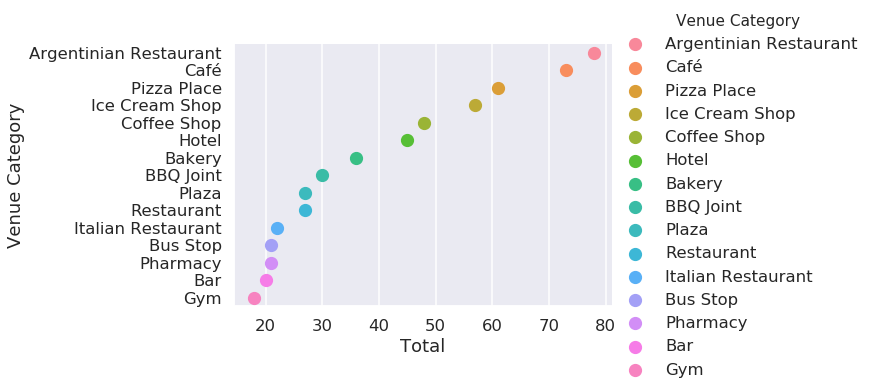

In [19]:
sns.set(rc={'figure.figsize':(10,7)})
#sns.set_style("ticks")
sns.set_context("talk")
sns.axes_style({'figure.facecolor': ('white')})
#sns.set_palette("RdBu")
sns.catplot(x="Total", y="Venue Category", data=venues, hue="Venue Category", kind="point", aspect=2);

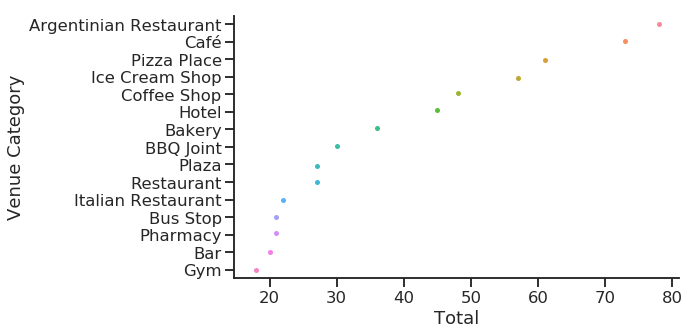

In [20]:
sns.set(rc={'figure.figsize':(10,6)})
sns.set_style("ticks")
sns.set_context("talk")
sns.axes_style({'figure.facecolor': ('white')})
sns.catplot(x="Total", y="Venue Category", data=venues, aspect=2);

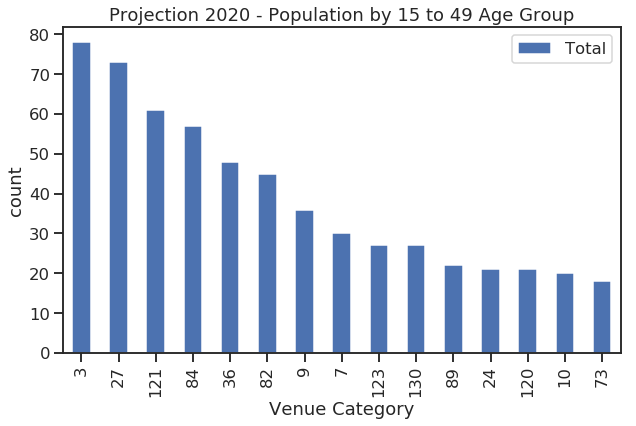

In [21]:

venues.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Venue Category') # add to x-label to the plot
plt.ylabel('count') # add y-label to the plot
plt.title('Projection 2020 - Population by 15 to 49 Age Group') # add title to the plot
plt.show()

#ax = sns.boxplot(x="Venue Category", y="count", data=venues, palette="Blues_d")

In [23]:
print("Records returned")
print(ba_venues.shape)

Records returned
(1086, 7)


In [24]:
# one hot encoding to analyze each neighborhood
ba_onehot = pd.get_dummies(ba_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ba_onehot['Neighborhood'] = ba_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [ba_onehot.columns[-1]] + list(ba_onehot.columns[:-1])
ba_onehot = ba_onehot[fixed_columns]

#group data by neighborhood
ba_grouped = ba_onehot.groupby('Neighborhood').mean().reset_index()
ba_grouped.head(1)

Neighborhood  American Restaurant  Arcade  Arepa Restaurant  \
0    AGRONOMIA                  0.0     0.0               0.0   

   Argentinian Restaurant  Art Gallery  Art Museum  Athletics & Sports  \
0                0.066667          0.0         0.0                 0.0   

   BBQ Joint  Bagel Shop    Bakery  Bar  Basketball Court  Basketball Stadium  \
0        0.0         0.0  0.066667  0.2               0.0                 0.0   

   Bed & Breakfast  Beer Bar  Beer Garden  Big Box Store  \
0              0.0       0.0          0.0            0.0   

   Bike Rental / Bike Share  Bistro  Bookstore  Breakfast Spot  Brewery  \
0                       0.0     0.0        0.0             0.0      0.0   

   Burger Joint  Bus Station  Bus Stop  Business Service  Cafeteria      Café  \
0      0.066667          0.0       0.0               0.0        0.0  0.066667   

   Camera Store  Candy Store  Cheese Shop  Chinese Restaurant  Chocolate Shop  \
0           0.0          0.0          0.0                 0.0             0.0   

   Church  Clothing Store  Cocktail Bar  Coffee Shop  Comfort Food Restaurant  \
0     0.0             0.0           0.0     0.066667                      0.0   

   Comic Shop  Concert Hall  Construction & Landscaping  Convenience Store  \
0         0.0           0.0                         0.0                0.0   

   Cosmetics Shop  Cultural Center  Dance Studio  Deli / Bodega  Dessert Shop  \
0             0.0              0.0           0.0            0.0           0.0   

   Diner  Eastern European Restaurant  Electronics Store  Empanada Restaurant  \
0    0.0                          0.0                0.0                  0.0   

   English Restaurant  Event Space  Falafel Restaurant  Farmers Market  \
0                 0.0          0.0                 0.0             0.0   

   Fast Food Restaurant  Flea Market  Food & Drink Shop  Food Service  \
0                   0.0          0.0                0.0           0.0   

   Fountain  French Restaurant  Fried Chicken Joint  Fruit & Vegetable Store  \
0       0.0                0.0                  0.0                      0.0   

   Furniture / Home Store  Garden  Garden Center  Gas Station  Gastropub  \
0                     0.0     0.0            0.0          0.0        0.0   

   General Entertainment  German Restaurant  Gift Shop  Gourmet Shop  \
0                    0.0                0.0        0.0           0.0   

   Grocery Store  Gym  Gym / Fitness Center  Harbor / Marina  Hardware Store  \
0            0.0  0.0                   0.0              0.0             0.0   

   Historic Site  History Museum  Hobby Shop  Hostel  Hot Dog Joint  Hotel  \
0            0.0             0.0         0.0     0.0            0.0    0.0   

   Hotel Bar  Ice Cream Shop  Indie Movie Theater  Indie Theater  \
0        0.0        0.066667                  0.0            0.0   

   Indoor Play Area  Intersection  Italian Restaurant  Japanese Restaurant  \
0               0.0      0.066667                 0.0                  0.0   

   Jewish Restaurant  Juice Bar  Lounge  Market  Mediterranean Restaurant  \
0                0.0        0.0     0.0     0.0                       0.0   

   Metro Station  Mexican Restaurant  Middle Eastern Restaurant  \
0            0.0                 0.0                        0.0   

   Monument / Landmark  Motel  Motorcycle Shop  Moving Target  Multiplex  \
0                  0.0    0.0              0.0            0.0        0.0   

   Museum  Music Venue  Nightclub  Office  Opera House  Organic Grocery  \
0     0.0          0.0        0.0     0.0          0.0              0.0   

   Outdoor Sculpture  Outdoor Supply Store  Paella Restaurant  \
0                0.0                   0.0                0.0   

   Paintball Field  Paper / Office Supplies Store  Park  Pastry Shop  \
0              0.0                            0.0   0.0          0.0   

   Performing Arts Venue  Peruvian Restaurant  Pet Store  Pharmacy  \
0       

In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

# Most common venues in each Neighborhood
num_top_venues = 3

indicators = ['st', 'nd', 'rd']
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

downtown_venues_sorted = pd.DataFrame(columns=columns)
downtown_venues_sorted['Neighborhood'] = ba_grouped['Neighborhood']

for ind in np.arange(ba_grouped.shape[0]):
    downtown_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ba_grouped.iloc[ind, :], num_top_venues)

downtown_venues_sorted.head(1)

# display the frequency of 3 venues by neighborhood.
num_top_venues = 3

for hood in ba_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = ba_grouped[ba_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----AGRONOMIA----
            venue  freq
0             Bar  0.20
1          Bakery  0.07
2  Ice Cream Shop  0.07


----ALMAGRO----
                    venue  freq
0  Argentinian Restaurant  0.17
1                     Bar  0.08
2          Ice Cream Shop  0.08


----BALVANERA----
                  venue  freq
0                  Café  0.14
1  Fast Food Restaurant  0.10
2                   Gym  0.05


----BARRACAS----
                    venue  freq
0  Argentinian Restaurant  0.25
1            Soccer Field  0.12
2                   Plaza  0.12


----BELGRANO----
                    venue  freq
0             Coffee Shop  0.11
1  Argentinian Restaurant  0.07
2                Tea Room  0.05


----BOCA----
                    venue  freq
0  Argentinian Restaurant  0.19
1             Pizza Place  0.10
2                 Theater  0.10


----BOEDO----
                    venue  freq
0  Argentinian Restaurant  0.33
1            Soccer Field  0.27
2             Pizza Place  0.07


----CABALLITO----

In [26]:
bagymsfilename= "https://raw.githubusercontent.com/karin-datascientist/Coursera_Capstone/master/caba_gimnasios.csv"
bagymsheaders = ['long', 'lat', 'periodo', 'razon_social', 'name', 'clasificacion', 'telefono', 'disposicion_2015_2016', 'disposicion_2017', 'disposicion_2018', 'calle', 'altura', 'piso', 'barrio' , 'comuna', 'codigo_postal' , 'codigo_postal_argentino']
ba_gyms = pd.read_csv(bagymsfilename, names = bagymsheaders)
#drop extra columns
ba_gyms.drop(columns=[ 'periodo', 'razon_social', 'clasificacion', 'telefono', 'disposicion_2015_2016', 'disposicion_2017', 'disposicion_2018', 'calle', 'altura', 'piso','codigo_postal' , 'codigo_postal_argentino'], inplace=True)
#drop empty rows
ba_gyms.dropna(subset=['lat', 'long', 'name'],inplace=True)
#drop first row
ba_gyms.drop(0, inplace=True)
# Convert dataframe to lowercase to combine with Foursquare dataset
ba_gyms = ba_gyms.applymap(lambda s:s.lower() if type(s) == str else s)
ba_gyms.shape

(178, 5)

In [27]:
# Filter Gym data
fs_gym_data = ba_venues[ba_venues['Venue Category'] == 'Gym'].reset_index(drop=True)
# Filter 'Gym / Fitness Center' data
fs_gymfit_data = ba_venues[ba_venues['Venue Category'] == 'Gym / Fitness Center'].reset_index(drop=True)
# Combine both categories
fsgym_data = fs_gym_data.append(fs_gymfit_data)
# Filter 'Sports Club' data
fs_gymsports_data = ba_venues[ba_venues['Venue Category'] == 'Gym / Fitness Center'].reset_index(drop=True)
# Combine both categories
fsgym_data = fsgym_data.append(fs_gym_data)
# Filter 'Athletics & Sports' data
fs_gymathletics_data = ba_venues[ba_venues['Venue Category'] == 'Athletics & Sports'].reset_index(drop=True)
# Combine both categories
fsgym_data = fsgym_data.append(fs_gymathletics_data)
# Convert df to lowercase for later merge with Gobierno Abierto dataset
fs_data = fsgym_data.applymap(lambda s:s.lower() if type(s) == str else s)
# Drop duplicates
fs_data.drop_duplicates(subset='Venue', keep='first', inplace=True)

In [28]:
# Combine dataframes
data = pd.concat ([ba_gyms, fs_data], axis=0)

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


##### Data cleaning

In [29]:
data.tail(2)

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
5         nunez               -34.5428                -58.4601   
6  villa crespo               -34.5947                -58.4443   

                                 Venue      Venue Category  Venue Latitude  \
5                               cenard  athletics & sports      -34.543963   
6  club atletico atlanta - sede social  athletics & sports      -34.593904   

   Venue Longitude barrio comuna  lat long name  
5       -58.455075    NaN    NaN  NaN  NaN  NaN  
6       -58.446985    NaN    NaN  NaN  NaN  NaN

In [30]:
# Convert Latitude/Longitude to float
data['lat'] = data['lat'].astype(str)
data['long'] = data['long'].astype(str)
data['Venue Latitude'] = data['Venue Latitude'].astype(str)
data['Venue Longitude'] = data['Venue Longitude'].astype(str)
# Create new column combining lat and long values from both datasets
data['longitude'] = [', '.join(str(x) for x in y) for y in map(tuple, data[['long', 'Neighborhood Longitude']].values)]
data['latitude'] = [', '.join(str(x) for x in y) for y in map(tuple, data[['lat', 'Neighborhood Latitude']].values)]

In [31]:
# Create new columns: merge and clean relevant columns - if "name" is empty, use "Venue"; if "barrio", "Neighborhood".
data['names'] = data['name'].fillna('') + data['Venue'].fillna('')
data['barrios'] = data['barrio'].fillna('') + data['Neighborhood'].fillna('')
data['latitude'] = data['lat'].fillna('') + data['Venue Latitude'].fillna('')
data['longitude'] = data['long'].fillna('') + data['Venue Longitude'].fillna('')
# Delete "NaN" keep data
data['latitude']= data['latitude'].str.strip(', nan,')
data['longitude']= data['longitude'].str.strip(', nan,')

In [36]:
map_ba = folium.Map(location=[-34.603722, -58.381592], zoom_start=13)

map_ba.choropleth(geo_data='http://cdn.buenosaires.gob.ar/datosabiertos/datasets/comunas/CABA_comunas.geojson', 
             key_on = 'feature.properties.COMUNAS', 
             data = data, 
             columns = ['comuna', 'freq'],
             fill_color = 'YlGn',
             fill_opacity = 0.7,
             line_opacity = 0.7,
             legend_name = 'number of gyms in each borough'
            )
for lat, long, names, comuna, freq in zip(data['latitude'], data['longitude'], data['names'], data['comuna'], data['freq']):
    
    label = '{} | {} ({})'.format(names, comuna, freq)
    label = folium.Popup(label)   
    
    folium.CircleMarker(
        [lat, long],
        radius = 3,
        fill = True,
        fill_opacity = 0.5,
        popup = label,
        
    ).add_to(map_ba)  

In [37]:
map_ba

In [38]:
map_barrios = folium.Map(location=[-34.603722, -58.381592], zoom_start=13)

map_baarrios.choropleth(geo_data='http://cdn.buenosaires.gob.ar/datosabiertos/datasets/barrios/barrios.geojson', 
             key_on = 'feature.properties.barrio', 
             data = data, 
             columns = ['barrios', 'freq'],
             fill_color = 'YlGn',
             fill_opacity = 0.7,
             line_opacity = 0.7,
             legend_name = 'Distribution of Gyms in Buenos Aires Neighborhoods'
            )
for lat, long, names, barrio, freq in zip(data['latitude'], data['longitude'], data['names'], data['barrios'], data['freq']):
    
    label = '{} | {} (comuna {})'.format(names, barrio, freq)
    label = folium.Popup(label)   
    
    folium.CircleMarker(
        [lat, long],
        radius = 3,
        fill = True,
        fill_opacity = 0.5,
        popup = label,
        
    ).add_to(map_barrios)  

In [39]:
map_barrios

In [40]:
folium.LayerControl().add_to(map_ba1) #Add layer control to toggle on/off
map_ba1.save('gyms_distribution.html') #save HTML

The maps clearly show that in some boroughs a few neighborhoods have less gyms, and therefore the competition would be low. These are the best locations to open new gyms.

## Expanding Dataset
<b> Population distribution in Neighborhoods and Borughs</b>
In addition to the existance of gyms, population distribution was explored as the existance of potential customers is an essential componenet for the success of any business. This study only considered the 15 to 49 age group population of the city. This group represents the majority of gym customers. 

In [41]:
caba_pofilename= "https://raw.githubusercontent.com/karin-datascientist/Coursera_Capstone/master/caba_total_population.csv"
caba_poheaders = ['barrios','Neighborhood_total_pop','comuna','Borough','comuna_total_pop']
caba_po = pd.read_csv(caba_pofilename, names = caba_poheaders)
caba_po.head(2)

barrios  Neighborhood_total_pop  comuna    Borough  comuna_total_pop
0  Constitucion                   44107       1  Comuna  1            205886
1     Monserrat                   39914       1  Comuna  1            205886

In [42]:
data.head(2)

comuna  longitude   latitude    names    barrios  freq
1     15 -58.483948 -34.597613   SPRINT  AGRONOMIA     7
2      5 -58.422979 -34.612240  QUALITY    ALMAGRO     7

In [43]:
# Convert neighborhood to ALL CAPS in both datasets
data['barrios'] =  data['barrios'].str.upper()
caba_po['barrios'] =  caba_po['barrios'].str.upper()

In [44]:
# Reset index
caba_po.set_index(['barrios'], inplace = True) 
# Drop extra column
caba_po.drop(columns=[ 'comuna_total_pop','comuna'], inplace=True)
caba_po.head(2)

Neighborhood_total_pop    Borough
barrios                                        
CONSTITUCION                   44107  Comuna  1
MONSERRAT                      39914  Comuna  1

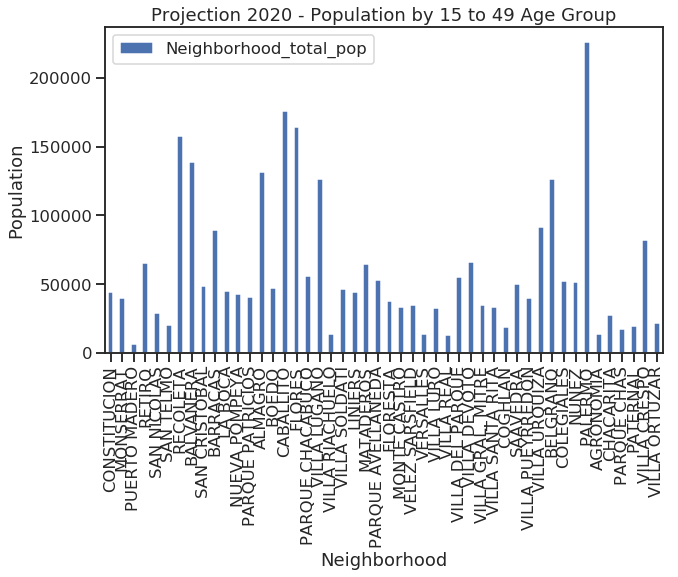

In [45]:
#Projection 2020 - Population by age group

caba_po.plot(kind='bar', figsize=(10, 6))
plt.xlabel("Neighborhood") # add to x-label to the plot
plt.ylabel('Population') # add y-label to the plot
plt.title('Projection 2020 - Population by 15 to 49 Age Group') # add title to the plot
plt.show()

## Expanding Dataset
The variation on the number of potential customers in each neighborhood is significant and should be taken into consideration. Income level, property value and crime rate are also important factors to consider.

In [46]:
data.head(2)

comuna  longitude   latitude    names    barrios  freq
1     15 -58.483948 -34.597613   SPRINT  AGRONOMIA     7
2      5 -58.422979 -34.612240  QUALITY    ALMAGRO     7

In [47]:
caba_po.head(2)

Neighborhood_total_pop    Borough
barrios                                        
CONSTITUCION                   44107  Comuna  1
MONSERRAT                      39914  Comuna  1

In [48]:
barrios.head(2)

barrios  comuna  crime  income  property_value  barrio_lat  \
0  CONSTITUCION       1  17.23   25564         3004.29    -34.6261   
1     SAN TELMO       1  17.23   25564         3004.29    -34.6218   

   barrio_long  comuna_lat  comuna_long  
0     -58.3860    -34.6079      -58.366  
1     -58.3714    -34.6079      -58.366

In [49]:
# Combine dataframes
data_population = pd.merge(data, caba_po, how='left', on=['barrios'])
data_population.shape

(188, 8)

In [50]:
# Combine dataframes
cluster_df = pd.merge(data_population, barrios, how='left', on=['barrios'])
cluster_df.shape

(188, 16)

In [55]:
cluster_df.describe()

longitude    latitude        freq  Neighborhood_total_pop    comuna_y  \
count  188.000000  188.000000  188.000000              188.000000  188.000000   
mean   -58.436211  -34.600011   16.574468           107183.845745    8.015957   
std      0.040944    0.028550    7.979907            68829.297182    4.858947   
min    -58.527058  -34.685965    1.000000             6726.000000    1.000000   
25%    -58.463594  -34.620114    9.000000            44125.750000    3.000000   
50%    -58.437858  -34.602078   14.000000            91563.000000    7.000000   
75%    -58.404041  -34.580067   25.000000           164310.000000   13.000000   
max    -58.363944  -34.538571   28.000000           225970.000000   15.000000   

            crime        income  property_value  barrio_lat  barrio_long  \
count  188.000000    188.000000      188.000000  188.000000   188.000000   
mean     7.945160  28709.739362     2947.261596  -34.600033   -58.437606   
std      4.233846   6789.831484      607.745779    0.029694     0.040329   
min      3.650000  15489.000000     2082.130000  -34.691900   -58.524000   
25%      4.380000  22799.000000     2413.500000  -34.616350   -58.460100   
50%      6.870000  26872.000000     3004.290000  -34.603700   -58.440600   
75%      9.700000  36299.000000     3378.500000  -34.578100   -58.405000   
max     17.230000  38686.000000     4125.000000  -34.542800   -58.362100   

       comuna_lat  comuna_long  
count  188.000000   188.000000  
mean   -34.601121   -58.434539  
std      0.030361     0.042532  
min    -34.674000   -58.514400  
25%    -34.620900   -58.457300  
50%    -34.607900   -58.445900  
75%    -34.578100   -58.399475  
max    -34.554400   -58.366000

In [58]:
#df_scalar =  data_population[['Neighborhood_total_pop', 'barrios_freq']]
#df =  data_population[['Neighborhood_total_pop', 'barrios_freq','names']]
cluster_df.Neighborhood_total_pop.describe()

count       188.000000
mean     107183.845745
std       68829.297182
min        6726.000000
25%       44125.750000
50%       91563.000000
75%      164310.000000
max      225970.000000
Name: Neighborhood_total_pop, dtype: float64

In [59]:
cluster_df.loc[cluster_df['Neighborhood_total_pop'] <= 49453.000000, 'Neighborhood_Population'] = 'LOW' 
cluster_df.loc[(cluster_df['Neighborhood_total_pop'] > 49453.000000)&(cluster_df['Neighborhood_total_pop'] < 164310.000000), 'Neighborhood_Population'] = 'MEDIUM' 
cluster_df.loc[cluster_df['Neighborhood_total_pop'] >= 164310.000000, 'Neighborhood_Population'] = 'HIGH' 

In [70]:
#long, lat = (np.asarray(cluster_df.longitude), np.asarray(cluster_df.latitude))
#cluster_df['long']=long.tolist()
#cluster_df['lat']=lat.tolist()
cluster_df.dropna(subset=['freq','Neighborhood_total_pop'], inplace=True)

In [71]:
# DBSCAN frequency and population
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
sklearn.utils.check_random_state(1000)
Clus_dataSet = cluster_df[['freq','Neighborhood_total_pop']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=3).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
cluster_df["Clus_Db"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 


# A sample of clusters
cluster_df[["names","barrios","freq","Clus_Db"]].head(2)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


names    barrios  freq  Clus_Db
0   SPRINT  AGRONOMIA     7        0
1  QUALITY    ALMAGRO     7        1

In [72]:
from sklearn import metrics
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(Clus_dataSet, labels))

Estimated number of clusters: 9
Estimated number of noise points: 5
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.659


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


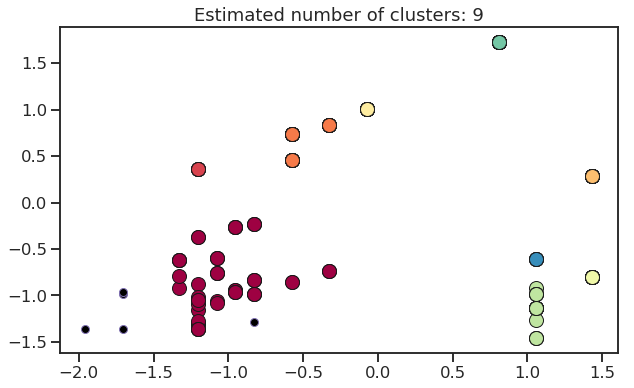

In [73]:
# Plot result
from sklearn.datasets import make_blobs
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = Clus_dataSet[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = Clus_dataSet[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='m', markersize=8)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [74]:
set(labels)

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8}

In [75]:
cluster01 = cluster_df.loc[cluster_df['Clus_Db'] == -1]
cluster0 = cluster_df.loc[cluster_df['Clus_Db'] == 0]
cluster1 = cluster_df.loc[cluster_df['Clus_Db'] == 1]
cluster2 = cluster_df.loc[cluster_df['Clus_Db'] == 2]
cluster3 = cluster_df.loc[cluster_df['Clus_Db'] == 3]
cluster4 = cluster_df.loc[cluster_df['Clus_Db'] == 4]
cluster5 = cluster_df.loc[cluster_df['Clus_Db'] == 5]
cluster6 = cluster_df.loc[cluster_df['Clus_Db'] == 6]
cluster7 = cluster_df.loc[cluster_df['Clus_Db'] == 7]
cluster8 = cluster_df.loc[cluster_df['Clus_Db'] == 8]

In [83]:
cluster01.shape

(5, 22)

In [108]:
#group data by neighborhood
cluster_grouped = cluster_df.groupby('Clus_Db')
cluster_grouped.first()

comuna_x  longitude   latitude                             names  \
Clus_Db                                                                     
-1            8.0 -58.474205 -34.685965         COMPLEJO DEPORTIVO 1°MAYO   
 0           15.0 -58.483948 -34.597613                            SPRINT   
 1            5.0 -58.422979 -34.612240                           QUALITY   
 2            3.0 -58.409756 -34.605156                CENTRAL PADDEL GYM   
 3           13.0 -58.460475 -34.562790            GIMNASIO URBAN FITNESS   
 4            6.0 -58.461433 -34.609795                        VITA SPORT   
 5           13.0 -58.460143 -34.576778                         OPEN CLUB   
 6            1.0 -58.378560 -34.623070  SATURN FITNESS & WELLNESS CENTER   
 7           14.0 -58.408321 -34.582690                             PRESS   
 8            1.0 -58.375112 -34.595775                         DREAM GYM   

                 barrios  freq  Neighborhood_total_pop    Borough  comuna_y  \
Clus_Db                                                                       
-1       VILLA RIACHUELO   1.0                   14084  Comuna  8         8   
 0             AGRONOMIA   7.0                   13912  Comuna 15        15   
 1               ALMAGRO   8.0                  131699  Comuna  5         5   
 2             BALVANERA  12.0                  138926  Comuna  3         3   
 3              BELGRANO  28.0                  126831  Comuna 13        13   
 4             CABALLITO  16.0                  176076  Comuna  6         6   
 5            COLEGIALES  28.0                   52551  Comuna 13        13   
 6          CONSTITUCION  24.0                   44107  Comuna  1         1   
 7               PALERMO  23.0                  225970  Comuna 14        14   
 8                RETIRO  24.0                   65413  Comuna  1         1   

         crime  income  property_value  barrio_lat  barrio_long  comuna_lat  \
Clus_Db                                                                       
-1        7.26   15489         2082.13    -34.6919     -58.4714    -34.6740   
 0        4.61   24723         2827.67    -34.5950     -58.4943    -34.5943   
 1        3.90   26610         2497.88    -34.6114     -58.4210    -34.6160   
 2        9.66   18064         2145.75    -34.6101     -58.4059    -34.6178   
 3        6.87   36299         3378.50    -34.5621     -58.4567    -34.5544   
 4        3.65   31417         2753.50    -34.6159     -58.4406    -34.6209   
 5        6.87   36299         3378.50    -34.5760     -58.4484    -34.5544   
 6       17.23   25564         3004.29    -34.6261     -58.3860    -34.6079   
 7        9.70   38686         4125.00    -34.5781     -58.4265    -34.5781   
 8       17.23   25564         3004.29    -34.5896     -58.3802    -34.6079   

         comuna_long Neighborhood_Population Neighborhood_Gyms_Freq  \
Clus_Db                                                               
-1          -58.4573                     LOW                    LOW   
 0          -58.4573                     LOW                 MEDIUM   
 1          -58.4202                  MEDIUM                 MEDIUM   
 2          -58.4002                  MEDIUM                 MEDIUM   
 3          -58.4573                  MEDIUM                   HIGH   
 4          -58.4459                    HIGH                   HIGH   
 5          -58.4573                  MEDIUM                   HIGH   
 6          -58.3660                     LOW                   HIGH   
 7          -58.4265                    HIGH                   HIGH   
 8          -58.3660                  MEDIUM                   HIGH   

        com_income com_crime property_value_avg  
Clus_Db                                          
-1             LOW    MEDIUM                LOW  
 0          MEDIUM    MEDIUM             MEDIUM  
 1          MEDIUM       LOW             MEDIUM  
 2             LOW    MEDIUM                LOW  
 3            HIGH    MEDIUM     

In [87]:
# First Choice (7): Medium Population, Property Value, and Income; low crime
map_Cluster2 = folium.Map(location=[-34.603722, -58.381592], zoom_start=13)

map_Cluster2.choropleth(geo_data='http://cdn.buenosaires.gob.ar/datosabiertos/datasets/barrios/barrios.geojson', 
             key_on = 'feature.properties.barrio', 
             data = cluster2, 
             columns = ['barrios', 'freq'],
             fill_color = 'YlGn',
             fill_opacity = 0,
             line_opacity = 0.7,
             legend_name = 'number of gyms in each neighborhood'
            )
for lat, long, names, barrios, comuna, freq in zip(cluster2['latitude'], cluster2['longitude'], cluster2['names'], cluster2['barrios'], cluster2['Borough'], cluster2['freq']):
    
    label = 'Gym: {}'.format(names)
    label = folium.Popup(label)   
    
    folium.CircleMarker(
        [lat, long],
        radius = 3,
        fill = True,
        fill_opacity = 0.5,
        popup = label,
        
    ).add_to(map_Cluster2)  

map_Cluster2

In [110]:
# Second Choice (32): Medium Population, Crime, and Income; low property value (biggest gym?)
map_Cluster2 = folium.Map(location=[-34.603722, -58.381592], zoom_start=13)

map_Cluster2.choropleth(geo_data='http://cdn.buenosaires.gob.ar/datosabiertos/datasets/barrios/barrios.geojson', 
             key_on = 'feature.properties.barrio', 
             data = data, 
             columns = ['barrios', 'freq'],
             fill_color = 'YlGn',
             fill_opacity = 0.7,
             line_opacity = 0.7,
             legend_name = 'number of gyms in each neighborhood'
            )
for lat, long, names, barrios, comuna, freq in zip(cluster2['latitude'], cluster2['longitude'], cluster2['names'], cluster2['barrios'], cluster2['Borough'], cluster2['freq']):
    
    label = '{} | {} {} ({})'.format(names, barrios, comuna, freq)
    label = folium.Popup(label)   
    
    folium.CircleMarker(
        [lat, long],
        radius = 3,
        fill = True,
        fill_opacity = 0.5,
        popup = label,
        
    ).add_to(map_Cluster2)  

map_Cluster2

In [111]:
# Thrid Choice (3): Medium Crime and Income; low Population and Property Value
map_Cluster01 = folium.Map(location=[-34.603722, -58.381592], zoom_start=13)

map_Cluster01.choropleth(geo_data='http://cdn.buenosaires.gob.ar/datosabiertos/datasets/barrios/barrios.geojson', 
             key_on = 'feature.properties.barrio', 
             data = data, 
             columns = ['barrios', 'freq'],
             fill_color = 'YlGn',
             fill_opacity = 0.7,
             line_opacity = 0.7,
             legend_name = 'number of gyms in each neighborhood'
            )
for lat, long, names, barrios, comuna, freq in zip(cluster01['latitude'], cluster01['longitude'], cluster01['names'], cluster01['barrios'], cluster01['Borough'], cluster01['freq']):
    
    label = '{} | {} {} ({})'.format(names, barrios, comuna, freq)
    label = folium.Popup(label)   
    
    folium.CircleMarker(
        [lat, long],
        radius = 3,
        fill = True,
        fill_opacity = 0.5,
        popup = label,
        
    ).add_to(map_Cluster01)  

map_Cluster01

Text(0.5, 1.0, 'Population in Relation to Gyms Distribution')

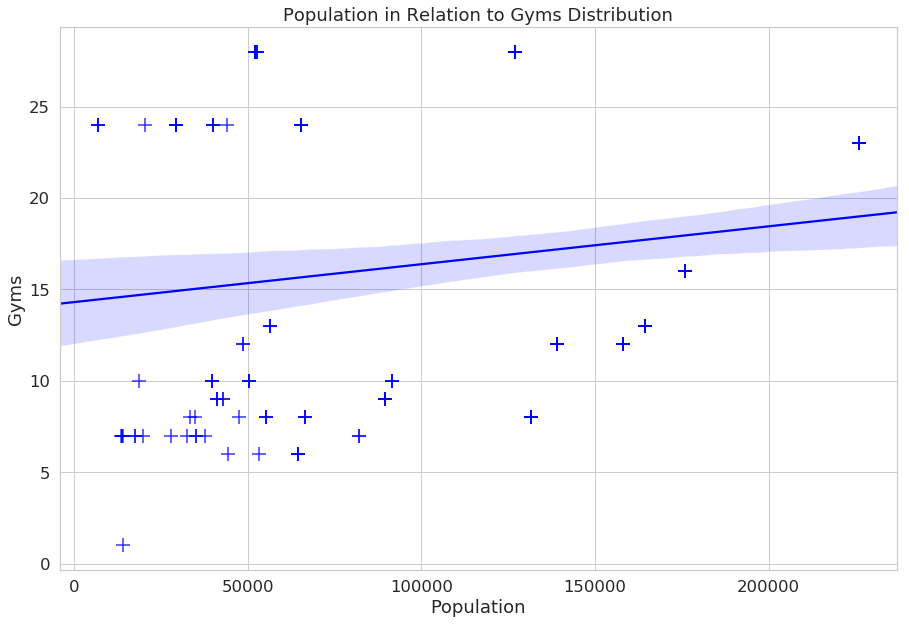

In [233]:
# define figure size
plt.figure(figsize=(15, 10))

# define background style and font size
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

# generate plot and add title and axes labels
ax = sns.regplot(x='Neighborhood_total_pop', y='freq', data=cluster_df, color='blue', marker='+',scatter_kws={'s': 200})
ax.set(xlabel='Population', ylabel='Gyms')
ax.set_title('Population in Relation to Gyms Distribution')



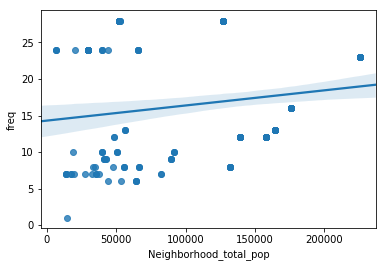

In [122]:
ax = sns.regplot(x='Neighborhood_total_pop', y='freq', data=cluster_df)

Text(0.5, 1.0, 'Distribution of Gyms in Relation to Property Value')

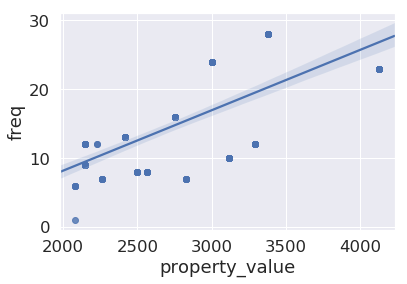

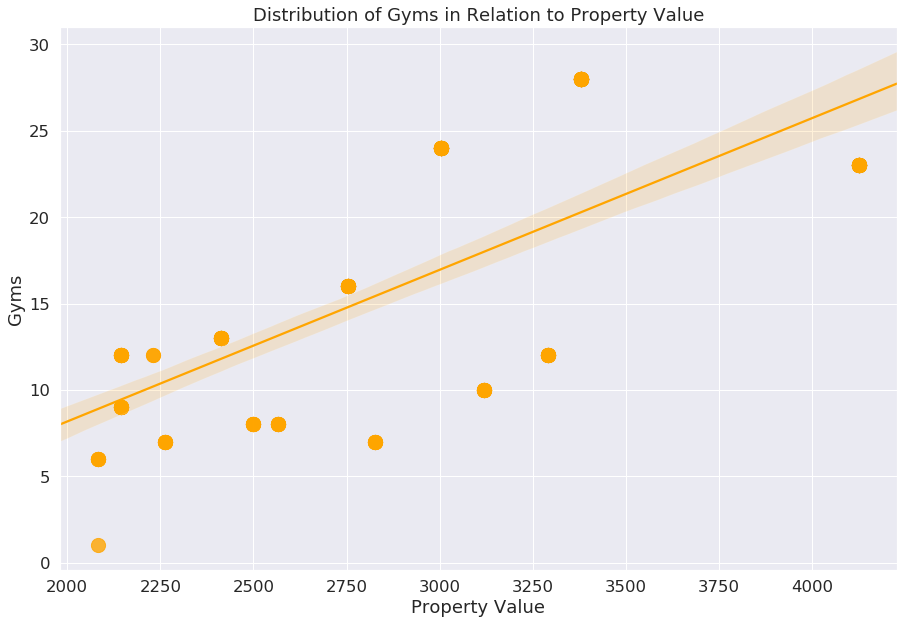

In [227]:
ax = sns.regplot(x='property_value', y='freq', data=cluster_df)

 # define figure size
plt.figure(figsize=(15, 10))

# define background style and font size
sns.set(font_scale=1.5)

# generate plot and add title and axes labels
ax = sns.regplot(x='property_value', y='freq', data=cluster_df, color='orange', scatter_kws={'s': 200})
ax.set(xlabel='Property Value', ylabel='Gyms')
ax.set_title('Distribution of Gyms in Relation to Property Value')

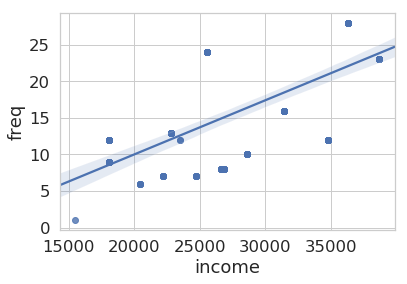

In [221]:
ax = sns.regplot(x='income', y='freq', data=cluster_df)

In [195]:
cluster_df.head(2)

comuna_x  longitude   latitude    names    barrios  freq  \
0      15.0 -58.483948 -34.597613   SPRINT  AGRONOMIA   7.0   
1       5.0 -58.422979 -34.612240  QUALITY    ALMAGRO   8.0   

   Neighborhood_total_pop    Borough  comuna_y  crime  income  property_value  \
0                   13912  Comuna 15        15   4.61   24723         2827.67   
1                  131699  Comuna  5         5   3.90   26610         2497.88   

   barrio_lat  barrio_long  comuna_lat  comuna_long Neighborhood_Population  \
0    -34.5950     -58.4943    -34.5943     -58.4573                     LOW   
1    -34.6114     -58.4210    -34.6160     -58.4202                  MEDIUM   

  Neighborhood_Gyms_Freq com_income com_crime property_value_avg  Clus_Db  
0                 MEDIUM     MEDIUM    MEDIUM             MEDIUM        0  
1                 MEDIUM     MEDIUM       LOW             MEDIUM        1

In [497]:
cluster_df["Neighborhood_Population_Cl"] = cluster_df["Neighborhood_Population"].cat.codes
cluster_df["Neighborhood_Gyms_Freq_Cl"] = cluster_df["Neighborhood_Gyms_Freq"].cat.codes
cluster_df["com_income_Cl"] = cluster_df["income"].cat.codes
cluster_df["crime_Cl"] = cluster_df["com_crime"].cat.codes
cluster_df["property_value_avg_Cl"] = cluster_df["property_value_avg"].cat.codes
cluster_df.head()

comuna_x                     names    barrios   latitude  longitude  freq  \
0      15.0                    SPRINT  AGRONOMIA -34.597613 -58.483948   6.0   
1       5.0                   QUALITY    ALMAGRO -34.612240 -58.422979   6.0   
2       5.0   HARDCORE OLD SCHOOL GYM    ALMAGRO -34.615827 -58.417925   6.0   
3       5.0           KELTIA XIMNASIO    ALMAGRO -34.614959 -58.427775   6.0   
4       5.0         MEGATLON CONGRESO    ALMAGRO -34.602188 -58.418411   6.0   

   Neighborhood_total_pop    Borough  barrios_freq  comuna_y crime income  \
0                 13912.0  Comuna 15             1        15  4.61  24723   
1                131699.0  Comuna  5             5         5  3.90  26610   
2                131699.0  Comuna  5             5         5  3.90  26610   
3                131699.0  Comuna  5             5         5  3.90  26610   
4                131699.0  Comuna  5             5         5  3.90  26610   

  property_value  barrio_lat  barrio_long  comuna_lat  comuna_long  \
0         MEDIUM    -34.5950     -58.4943    -34.5943     -58.4573   
1         MEDIUM    -34.6114     -58.4210    -34.6160     -58.4202   
2         MEDIUM    -34.6114     -58.4210    -34.6160     -58.4202   
3         MEDIUM    -34.6114     -58.4210    -34.6160     -58.4202   
4         MEDIUM    -34.6114     -58.4210    -34.6160     -58.4202   

  Neighborhood_Population Neighborhood_Gyms Neighborhood_Gyms_Freq com_income  \
0                     LOW               LOW                    LOW     MEDIUM   
1                  MEDIUM            MEDIUM                 MEDIUM     MEDIUM   
2                  MEDIUM            MEDIUM                 MEDIUM     MEDIUM   
3                  MEDIUM            MEDIUM                 MEDIUM     MEDIUM   
4                  MEDIUM            MEDIUM                 MEDIUM     MEDIUM   

  property_value_avg com_crime  Neighborhood_Population_Cl  \
0             MEDIUM       NaN                           1   
1             MEDIUM       LOW                           2   
2             MEDIUM       LOW                           2   
3             MEDIUM       LOW                           2   
4             MEDIUM       LOW                           2   

   Neighborhood_Gyms_Freq_Cl  com_income_Cl  crime_Cl  property_value_avg_Cl  
0                          0              6        -1                      2  
1                          1              8         1                      2  
2                          1              8         1                      2  
3                          1              8         1                      2  
4                          1              8         1                      2

In [367]:
X_K_Nearest = df_scalar[['Neighborhood_total_pop', 'barrios_freq']] .values  #.astype(float)
X_K_Nearest[0:5]
Clus_dataSet = StandardScaler().fit_transform(X_K_Nearest)
Clus_dataSet

array([[-1.39175767, -1.27922146],
       [ 0.32878585, -0.55897437],
       [ 0.32878585, -0.55897437],
       [ 0.32878585, -0.55897437],
       [ 0.32878585, -0.55897437],
       [ 0.32878585, -0.55897437],
       [ 0.4343524 ,  0.0172233 ],
       [ 0.4343524 ,  0.0172233 ],
       [ 0.4343524 ,  0.0172233 ],
       [ 0.4343524 ,  0.0172233 ],
       [ 0.4343524 ,  0.0172233 ],
       [ 0.4343524 ,  0.0172233 ],
       [ 0.4343524 ,  0.0172233 ],
       [ 0.4343524 ,  0.0172233 ],
       [ 0.4343524 ,  0.0172233 ],
       [ 0.4343524 ,  0.0172233 ],
       [-0.28832641, -0.84707321],
       [-0.28832641, -0.84707321],
       [-0.28832641, -0.84707321],
       [-0.28832641, -0.84707321],
       [ 0.25767778,  0.73747039],
       [ 0.25767778,  0.73747039],
       [ 0.25767778,  0.73747039],
       [ 0.25767778,  0.73747039],
       [ 0.25767778,  0.73747039],
       [ 0.25767778,  0.73747039],
       [ 0.25767778,  0.73747039],
       [ 0.25767778,  0.73747039],
       [ 0.25767778,

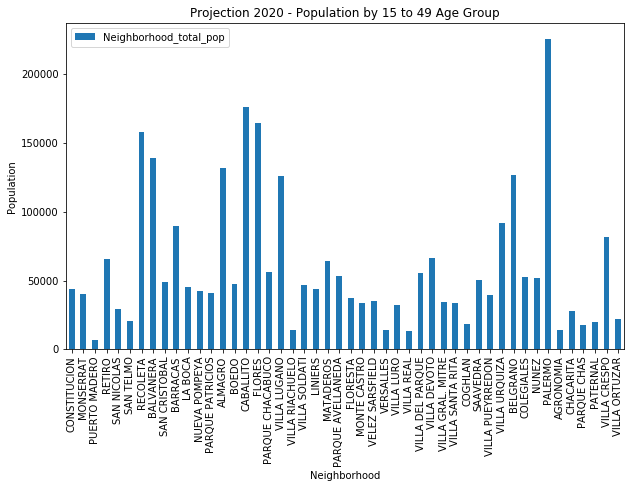

In [214]:
#Projection 2020 - Population by age group

caba_po.plot(kind='bar', figsize=(10, 6))
plt.xlabel("Neighborhood") # add to x-label to the plot
plt.ylabel('Population') # add y-label to the plot
plt.title('Projection 2020 - Population by 15 to 49 Age Group') # add title to the plot
plt.show()

In [270]:
cluster_df.dropna(subset=['barrios','barrio_lat','barrio_long','comuna_lat','comuna_long','Neighborhood_Population','Neighborhood_Gyms_Freq','com_income','com_crime','property_value_avg','Clus_Db',
'comuna_x','longitude','latitude','names'], inplace=True)

In [271]:
cluster_violin = cluster_df[['barrios','freq','Neighborhood_total_pop','crime','income','property_value']].copy()

In [274]:

cols_to_norm = ['freq','Neighborhood_total_pop','crime','income','property_value']
cluster_violin[cols_to_norm] = StandardScaler().fit_transform(cluster_violin[cols_to_norm])

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.



In [288]:
cluster_violin.head(2)
cluster_violin.rename(columns = {'freq':'Gyms', 'Neighborhood_total_pop':'Population', 
                              'crime':'Crime', 'income':'Income', 
                              'property_value':'Property Value'}, inplace = True)

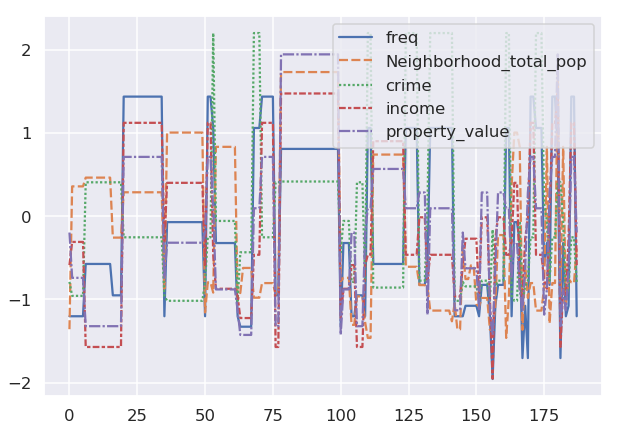

In [261]:
sns.lineplot(data=cluster_violin)

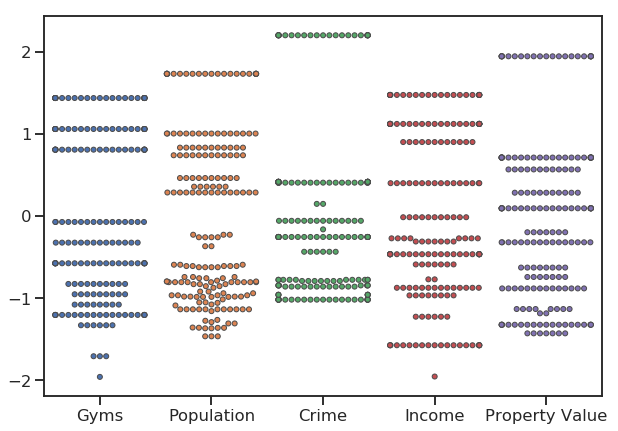

In [304]:
ax = sns.swarmplot(data=cluster_violin, linewidth=1)
sns.set(rc={'figure.figsize':(10,7)})
#sns.set_style("ticks")
sns.set_context("talk")
sns.axes_style({'figure.facecolor': ('white')})
sns.set_palette("RdBu")

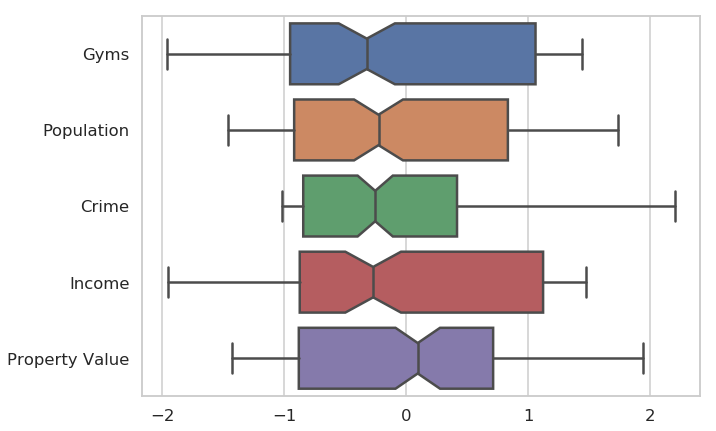

In [301]:
ax = sns.boxplot(data=cluster_violin, linewidth=2.5, orient="h", notch=True)
#handles, _ = ax.get_legend_handles_labels()
#ax.legend(handles, ["Man", "Woman"])
#sns.set_style("whitegrid") 